In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:000000000000:1234abcd-12ab-34cd-56ef-1234567890ab"


# MNIST Training with MXNet and Gluon (Testing)

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using MXNet and the Gluon API.



In [2]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## Download training and test data

In [3]:
import os

for inner_dir in ["train", "test"]:
    data_dir = "./data/{}/".format(inner_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

s3 = boto3.client("s3")
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-images-idx3-ubyte.gz",
    "./data/train/train-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-labels-idx1-ubyte.gz",
    "./data/train/train-labels-idx1-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-images-idx3-ubyte.gz",
    "./data/test/t10k-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-labels-idx1-ubyte.gz",
    "./data/test/t10k-labels-idx1-ubyte.gz",
)

## Uploading the data

We use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we will use this later when we start the training job.

In [4]:
inputs = sagemaker_session.upload_data(path="data", key_prefix="data/DEMO-mnist")

## Implement the training function

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a `train` function. The `train` function will check for the validation accuracy at the end of every epoch and checkpoints the best model so far, along with the optimizer state, in the folder `/opt/ml/checkpoints` if the folder path exists, else it will skip the checkpointing. When SageMaker calls your function, it will pass in arguments that describe the training environment. Check the script below to see how this works.

The script here is an adaptation of the [Gluon MNIST example](https://github.com/apache/incubator-mxnet/blob/master/example/gluon/mnist.py) provided by the [Apache MXNet](https://mxnet.incubator.apache.org/) project. 

In [5]:
!cat 'mnist.py'

from __future__ import print_function

import argparse
import json
import logging
import os
import time

import mxnet as mx
import numpy as np
from mxnet import autograd, gluon
from mxnet.gluon import nn

logging.basicConfig(level=logging.DEBUG)

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------------------------------------------ #


def train(args):
    # SageMaker passes num_cpus, num_gpus and other args we can use to tailor training to
    # the current container environment, but here we just use simple cpu context.
    ctx = mx.cpu()

    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = args.batch_size
    epochs = args.epochs
    learning_rate = args.learning_rate
    momentum = args.momentum
    log_interval = args.log_interval

    num_gpus = int(os.environ["SM_NUM_GPUS"])
    current_host = args.current_host
    hosts = args.hosts
  

## Run the training script on SageMaker

The ```MXNet``` class allows us to run our training function on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on a single c4.xlarge instance. 

In [6]:
m = MXNet(
    "mnist.py",
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version="1.6.0",
    py_version="py3",
    hyperparameters={
        "batch-size": 100,
        "epochs": 20,
        "learning-rate": 0.1,
        "momentum": 0.9,
        "log-interval": 100,
    },
)

After we've constructed our `MXNet` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [7]:
m.fit(inputs)

2022-03-24 00:08:01 Starting - Starting the training job.

.

.


2022-03-24 00:08:03 Starting - Launching requested ML instancesProfilerReport-1648080480: InProgress
.

.

.

.

.

.


2022-03-24 00:09:31 Starting - Preparing the instances for training.

.

.

.

.

.

.

.

.


2022-03-24 00:10:57 Downloading - Downloading input data
2022-03-24 00:10:57 Training - Downloading the training image.

.

.


2022-03-24 00:11:17 Training - Training image download completed. Training in progress.

2022-03-24 00:11:17,316 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-03-24 00:11:17,319 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-24 00:11:17,339 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":100,"epochs":20,"learning-rate":0.1,"log-interval":100,"momentum":0.9}', 'SM_USER_ENTRY_POINT': 'mnist.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"training":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_CHANNELS': '["training"]', 'SM_CURRENT_HOST': 'algo-1', 'SM_MODULE_NAME': 'mnist', 'SM_LOG_LEVEL': '20', 'SM_FRAMEWORK_MODULE': 'sagemaker_mxnet_container.training:main', 

[Epoch 0 Batch 300] Training: accuracy=0.887276, 3725.389255 samples/s
[Epoch 0 Batch 400] Training: accuracy=0.901895, 4316.148883 samples/s
[Epoch 0 Batch 500] Training: accuracy=0.911437, 3774.877375 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.12144341319799423,Timestamp=1648080695.0513175,IterationNumber=500)
[Epoch 0] Training: accuracy=0.918217


[Epoch 0] Validation: accuracy=0.951800
[Epoch 1 Batch 100] Training: accuracy=0.959109, 3873.929990 samples/s
[Epoch 1 Batch 200] Training: accuracy=0.960796, 4578.784538 samples/s
[Epoch 1 Batch 300] Training: accuracy=0.961728, 4021.230250 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.10863106697797775,Timestamp=1648080707.4529135,IterationNumber=1000)


[Epoch 1 Batch 400] Training: accuracy=0.962344, 4582.135990 samples/s
[Epoch 1 Batch 500] Training: accuracy=0.963373, 3788.208092 samples/s
[Epoch 1] Training: accuracy=0.963867
[Epoch 1] Validation: accuracy=0.966500
[Epoch 2 Batch 100] Training: accuracy=0.973663, 3496.418806 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0765862911939621,Timestamp=1648080720.0718277,IterationNumber=1500)


[Epoch 2 Batch 200] Training: accuracy=0.973184, 3750.976131 samples/s
[Epoch 2 Batch 300] Training: accuracy=0.974950, 3431.400686 samples/s


[Epoch 2 Batch 400] Training: accuracy=0.974264, 3710.427190 samples/s
[Epoch 2 Batch 500] Training: accuracy=0.974311, 1544.163786 samples/s
[Epoch 2] Training: accuracy=0.973517
[Epoch 2] Validation: accuracy=0.969400
[Epoch 3 Batch 100] Training: accuracy=0.979802, 3809.713429 samples/s


[Epoch 3 Batch 200] Training: accuracy=0.980995, 3853.252611 samples/s
[Epoch 3 Batch 300] Training: accuracy=0.979468, 3522.405207 samples/s
[Epoch 3 Batch 400] Training: accuracy=0.979052, 3733.081750 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.12308607995510101,Timestamp=1648080745.8174295,IterationNumber=2500)
[Epoch 3 Batch 500] Training: accuracy=0.979681, 3807.949449 samples/s


[Epoch 3] Training: accuracy=0.979600
[Epoch 3] Validation: accuracy=0.968300
[Epoch 4 Batch 100] Training: accuracy=0.984653, 3720.135526 samples/s
[Epoch 4 Batch 200] Training: accuracy=0.985174, 3431.934148 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.08101725578308105,Timestamp=1648080758.127737,IterationNumber=3000)


[Epoch 4 Batch 300] Training: accuracy=0.984352, 3718.123875 samples/s
[Epoch 4 Batch 400] Training: accuracy=0.984015, 3764.611270 samples/s
[Epoch 4 Batch 500] Training: accuracy=0.982854, 3766.775034 samples/s
[Epoch 4] Training: accuracy=0.982850


[Epoch 4] Validation: accuracy=0.971700
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.04884176701307297,Timestamp=1648080770.4387887,IterationNumber=3500)
[Epoch 5 Batch 100] Training: accuracy=0.987624, 3410.862900 samples/s
[Epoch 5 Batch 200] Training: accuracy=0.986070, 3028.400205 samples/s
[Epoch 5 Batch 300] Training: accuracy=0.985183, 3625.217376 samples/s


[Epoch 5 Batch 400] Training: accuracy=0.985262, 3787.763359 samples/s
[Epoch 5 Batch 500] Training: accuracy=0.985150, 3104.959877 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.2202380895614624,Timestamp=1648080783.4364316,IterationNumber=4000)
[Epoch 5] Training: accuracy=0.984933
[Epoch 5] Validation: accuracy=0.969800
[Epoch 6 Batch 100] Training: accuracy=0.987723, 4043.443137 samples/s
[Epoch 6 Batch 200] Training: accuracy=0.987662, 3747.557652 samples/s


[Epoch 6 Batch 300] Training: accuracy=0.987907, 3677.472075 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.04575372114777565,Timestamp=1648080796.5221465,IterationNumber=4500)
[Epoch 6 Batch 400] Training: accuracy=0.987282, 3622.305706 samples/s
[Epoch 6 Batch 500] Training: accuracy=0.986806, 3584.385041 samples/s
[Epoch 6] Training: accuracy=0.986933


[Epoch 6] Validation: accuracy=0.976400
[Epoch 7 Batch 100] Training: accuracy=0.989109, 4093.042138 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.004010808188468218,Timestamp=1648080808.933693,IterationNumber=5000)
[Epoch 7 Batch 200] Training: accuracy=0.988856, 3764.949194 samples/s
[Epoch 7 Batch 300] Training: accuracy=0.989435, 3813.662360 samples/s


[Epoch 7 Batch 400] Training: accuracy=0.989327, 3820.192544 samples/s
[Epoch 7 Batch 500] Training: accuracy=0.989002, 3843.683217 samples/s
[Epoch 7] Training: accuracy=0.988717
[Epoch 7] Validation: accuracy=0.973900


[Epoch 8 Batch 100] Training: accuracy=0.992079, 4108.880377 samples/s
[Epoch 8 Batch 200] Training: accuracy=0.992239, 3703.318088 samples/s
[Epoch 8 Batch 300] Training: accuracy=0.990465, 3825.628209 samples/s
[Epoch 8 Batch 400] Training: accuracy=0.989950, 3787.558132 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.06909457594156265,Timestamp=1648080833.9968865,IterationNumber=6000)


[Epoch 8 Batch 500] Training: accuracy=0.989701, 3723.008370 samples/s
[Epoch 8] Training: accuracy=0.989600
[Epoch 8] Validation: accuracy=0.975400
[Epoch 9 Batch 100] Training: accuracy=0.992376, 3130.708426 samples/s
[Epoch 9 Batch 200] Training: accuracy=0.992040, 3980.661877 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0052797021344304085,Timestamp=1648080847.0487523,IterationNumber=6500)
[Epoch 9 Batch 300] Training: accuracy=0.991528, 4433.537694 samples/s


[Epoch 9 Batch 400] Training: accuracy=0.991571, 3842.767618 samples/s
[Epoch 9 Batch 500] Training: accuracy=0.991018, 4060.628122 samples/s
[Epoch 9] Training: accuracy=0.990500
[Epoch 9] Validation: accuracy=0.975200
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.033580511808395386,Timestamp=1648080859.4220748,IterationNumber=7000)
[Epoch 10 Batch 100] Training: accuracy=0.990792, 3791.701170 samples/s


[Epoch 10 Batch 200] Training: accuracy=0.992040, 3889.990076 samples/s
[Epoch 10 Batch 300] Training: accuracy=0.991827, 4339.638493 samples/s


[Epoch 10 Batch 400] Training: accuracy=0.991571, 4016.840008 samples/s
[Epoch 10 Batch 500] Training: accuracy=0.991138, 3360.982098 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.05215322971343994,Timestamp=1648080872.3773694,IterationNumber=7500)
[Epoch 10] Training: accuracy=0.990883
[Epoch 10] Validation: accuracy=0.973900
[Epoch 11 Batch 100] Training: accuracy=0.992475, 3870.855329 samples/s
[Epoch 11 Batch 200] Training: accuracy=0.993184, 4342.064453 samples/s


[Epoch 11 Batch 300] Training: accuracy=0.993289, 3468.861082 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0019428953528404236,Timestamp=1648080884.8006346,IterationNumber=8000)
[Epoch 11 Batch 400] Training: accuracy=0.992843, 3682.476580 samples/s
[Epoch 11 Batch 500] Training: accuracy=0.993114, 4145.142609 samples/s
[Epoch 11] Training: accuracy=0.992833


[Epoch 11] Validation: accuracy=0.965600
[Epoch 12 Batch 100] Training: accuracy=0.991881, 3921.559534 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.007991921156644821,Timestamp=1648080897.1165683,IterationNumber=8500)
[Epoch 12 Batch 200] Training: accuracy=0.993234, 4259.820032 samples/s
[Epoch 12 Batch 300] Training: accuracy=0.993322, 3720.861573 samples/s


[Epoch 12 Batch 400] Training: accuracy=0.992818, 3632.344052 samples/s
[Epoch 12 Batch 500] Training: accuracy=0.992794, 3202.883455 samples/s


[Epoch 12] Training: accuracy=0.992417
[Epoch 12] Validation: accuracy=0.973400
[Epoch 13 Batch 100] Training: accuracy=0.991980, 3220.516443 samples/s
[Epoch 13 Batch 200] Training: accuracy=0.991443, 4666.767546 samples/s
[Epoch 13 Batch 300] Training: accuracy=0.991694, 4677.488569 samples/s


[Epoch 13 Batch 400] Training: accuracy=0.991820, 3470.784304 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.004802917130291462,Timestamp=1648080922.7416868,IterationNumber=9500)
[Epoch 13 Batch 500] Training: accuracy=0.991277, 4620.753324 samples/s
[Epoch 13] Training: accuracy=0.990950
[Epoch 13] Validation: accuracy=0.972300


[Epoch 14 Batch 100] Training: accuracy=0.993861, 3803.529390 samples/s
[Epoch 14 Batch 200] Training: accuracy=0.992438, 3288.283302 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0119701586663723,Timestamp=1648080935.382331,IterationNumber=10000)
[Epoch 14 Batch 300] Training: accuracy=0.992957, 4009.582533 samples/s
[Epoch 14 Batch 400] Training: accuracy=0.993067, 4575.787395 samples/s
[Epoch 14 Batch 500] Training: accuracy=0.992994, 4008.432963 samples/s
[Epoch 14] Training: accuracy=0.992850


[Epoch 14] Validation: accuracy=0.973900
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.012016335502266884,Timestamp=1648080947.6828969,IterationNumber=10500)
[Epoch 15 Batch 100] Training: accuracy=0.993960, 4065.272259 samples/s
[Epoch 15 Batch 200] Training: accuracy=0.994826, 3856.618485 samples/s
[Epoch 15 Batch 300] Training: accuracy=0.995183, 4194.765424 samples/s


[Epoch 15 Batch 400] Training: accuracy=0.994963, 3772.398906 samples/s
[Epoch 15 Batch 500] Training: accuracy=0.994731, 3474.896233 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0007855490548536181,Timestamp=1648080960.4154835,IterationNumber=11000)
[Epoch 15] Training: accuracy=0.994367
[Epoch 15] Validation: accuracy=0.975800


[Epoch 16 Batch 100] Training: accuracy=0.993762, 3728.568508 samples/s
[Epoch 16 Batch 200] Training: accuracy=0.994577, 3632.344052 samples/s
[Epoch 16 Batch 300] Training: accuracy=0.994651, 3533.563046 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0009178981417790055,Timestamp=1648080973.4911406,IterationNumber=11500)
[Epoch 16 Batch 400] Training: accuracy=0.994713, 3731.022888 samples/s


[Epoch 16 Batch 500] Training: accuracy=0.994631, 2888.499866 samples/s
[Epoch 16] Training: accuracy=0.994800
[Epoch 16] Validation: accuracy=0.976500


[Epoch 17 Batch 100] Training: accuracy=0.996139, 3426.718954 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0002546696923673153,Timestamp=1648080985.8981893,IterationNumber=12000)
[Epoch 17 Batch 200] Training: accuracy=0.995323, 3976.133552 samples/s
[Epoch 17 Batch 300] Training: accuracy=0.995316, 4058.427836 samples/s
[Epoch 17 Batch 400] Training: accuracy=0.994863, 3206.360273 samples/s
[Epoch 17 Batch 500] Training: accuracy=0.994651, 3851.837158 samples/s
[Epoch 17] Training: accuracy=0.994400
[Epoch 17] Validation: accuracy=0.975300
[Epoch 18 Batch 100] Training: accuracy=0.994158, 3754.098419 samples/s
[Epoch 18 Batch 200] Training: accuracy=0.995274, 3974.739396 samples/s
[Epoch 18 Batch 300] Training: accuracy=0.995847, 4029.187881 samples/s
[Epoch 18 Batch 400] Training: accuracy=0.995137, 3506.796539 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',


2022-03-24 00:17:39 Uploading - Uploading generated training model
2022-03-24 00:17:39 Completed - Training job completed
ProfilerReport-1648080480: NoIssuesFound


Training seconds: 415
Billable seconds: 415


After training, we use the MXNet object to build and deploy an MXNetPredictor object. This creates a SageMaker endpoint that we can use to perform inference. 

This allows us to perform inference on json encoded multi-dimensional arrays. 

In [8]:
predictor = m.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-

-

-

-

-

-

!

We can now use this predictor to classify hand-written digits. Manually drawing into the image box loads the pixel data into a 'data' variable in this notebook, which we can then pass to the MXNet predictor. 

In [9]:
from IPython.display import HTML

HTML(open("input.html").read())

Fetch the first image from the test dataset and display it.

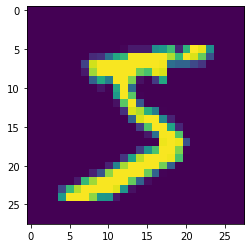

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

f = gzip.open("data/train/train-images-idx3-ubyte.gz", "r")

image_size = 28

f.read(16)
buf = f.read(image_size * image_size)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(1, image_size, image_size, 1)

image = np.asarray(data).squeeze()
plt.imshow(image)
plt.show()

The predictor runs inference on our input data and returns the predicted digit (as a float value, so we convert to int for display).

In [11]:
response = predictor.predict(data)
print(int(response))

5


## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [12]:
predictor.delete_endpoint()